# Simple Neural Network using PyTorch models for Fashion MNIST case

---

How to Use This Notebook
---

**Recommended Setup**
- For the best experience, **run this notebook on [Google Colab](https://colab.research.google.com/)**—especially if your local machine is slow.  
- In Colab, **enable GPU support** by going to:  
  `Runtime > Change runtime type > Hardware accelerator > GPU`

This notebook will demonstrate how PyTorch models solve regression tasks. The dataset originally comes from the 1990 U.S. census.

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bureau publishes sample data (a block group typically has a population
of 600 to 3,000 people).

## Preprocessing

### *Library install*

In [59]:
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

from typing import Optional, Callable, Tuple, Dict
from numpy.typing import NDArray

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from itertools import product
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
from sklearn.metrics import mean_squared_error, mean_absolute_error
from typing import Optional, Callable

RSEED=42

In [2]:
# version?
pt.__version__

'2.6.0+cpu'

### *Dataset loading*

In [3]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [4]:
housing.data.shape

(20640, 8)

In [8]:
housing.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [5]:
housing.target.shape

(20640,)

### *EDA*

In [31]:
# Check the missing values

df = pd.DataFrame(housing.data, columns=housing.feature_names)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [32]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


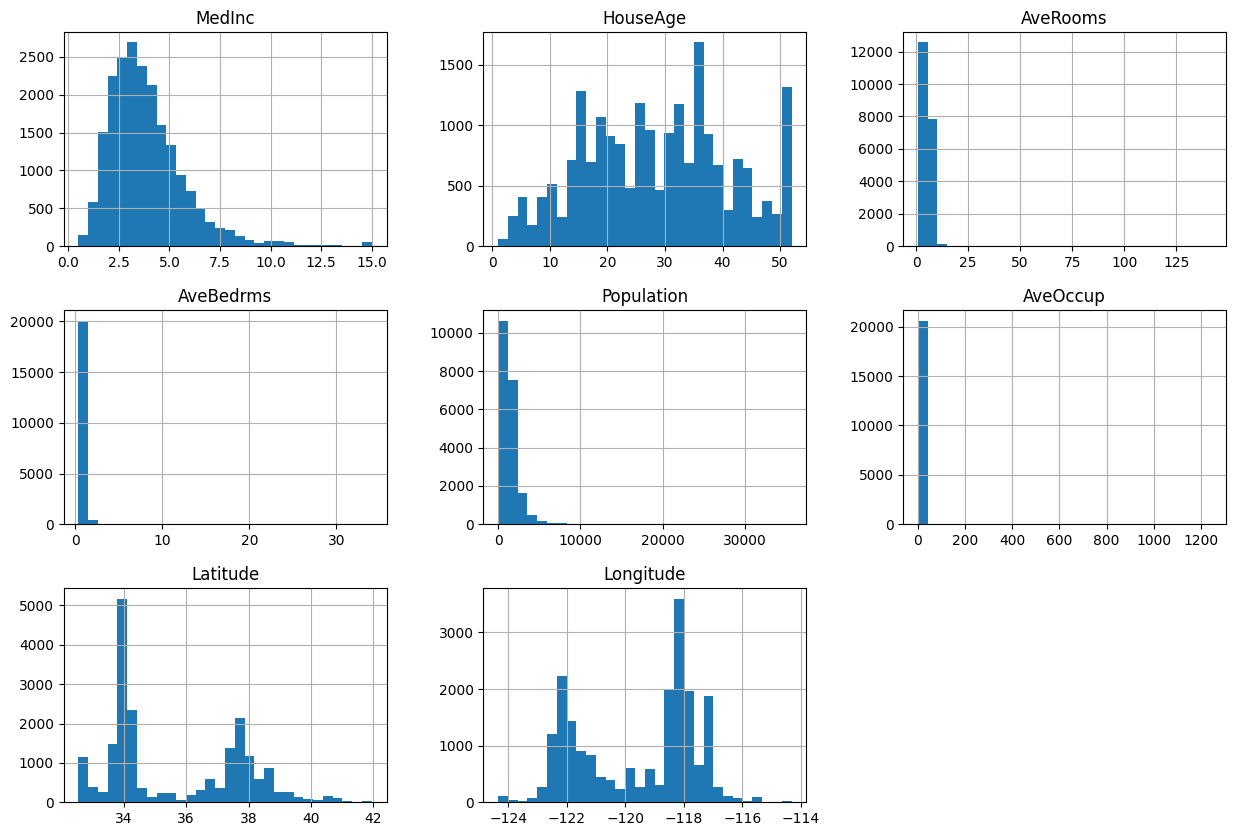

In [33]:
# See the distribution per feature

df.hist(bins=30, figsize=(15, 10))
plt.show()

<Axes: >

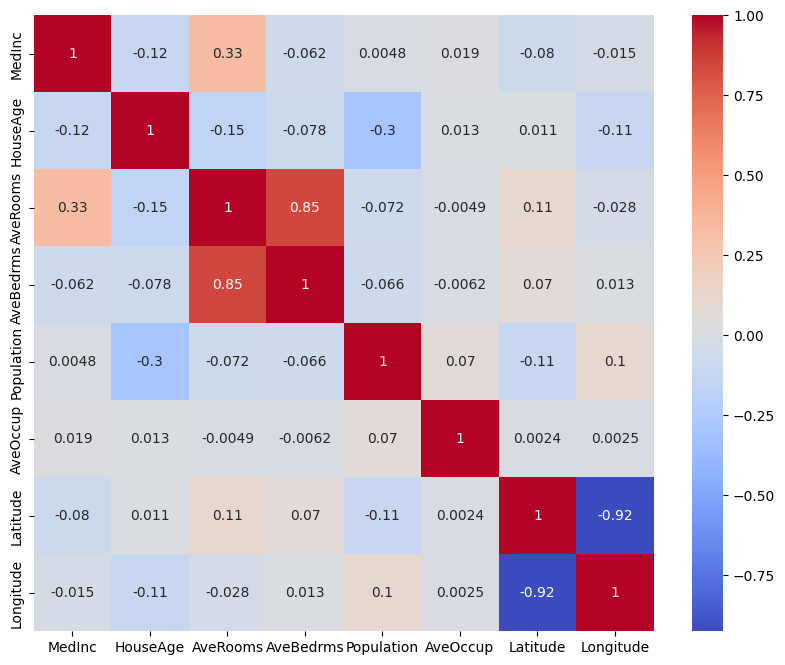

In [34]:
# See the correlation among features

corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm")

In [35]:
# See the strongest correlations

df["MedHouseValue"] = housing.target
print("\nTop correlations with Median House Value:")
print(df.corr()["MedHouseValue"].sort_values(ascending=False))


Top correlations with Median House Value:
MedHouseValue    1.000000
MedInc           0.688075
AveRooms         0.151948
HouseAge         0.105623
AveOccup        -0.023737
Population      -0.024650
Longitude       -0.045967
AveBedrms       -0.046701
Latitude        -0.144160
Name: MedHouseValue, dtype: float64


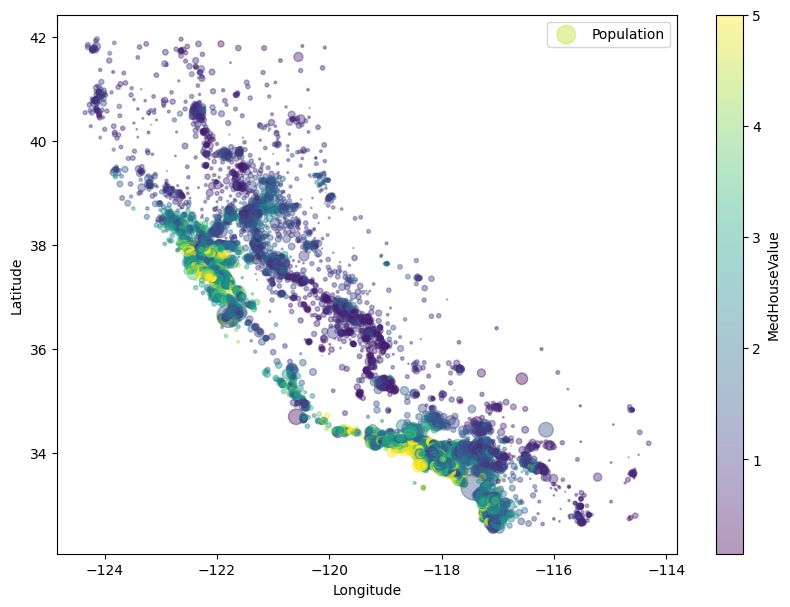

In [37]:
# See the house price by location (longitude)

df.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
        s=df["Population"]/100, label="Population", figsize=(10,7),
        c="MedHouseValue", cmap="viridis", colorbar=True)
plt.legend()


<Axes: xlabel='MedHouseValue', ylabel='Count'>

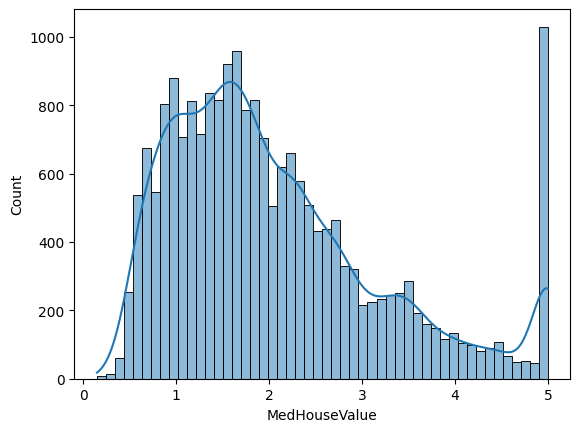

In [40]:
# See the target distribution
sns.histplot(df["MedHouseValue"], bins=50, kde=True)

# It seems that the dataset was censored up to 5.0 and right-skewed.

### *Feature Engineering*

#### Problem 1: Log Transform the Target

It seems that MedHouseValue is right-skewed (many lower-priced houses, few very expensive ones). Therefore, we transform the target so the regression models focus on relative errors rather than absolute errors for high-value houses.

<Axes: xlabel='MedHouseValue_log', ylabel='Count'>

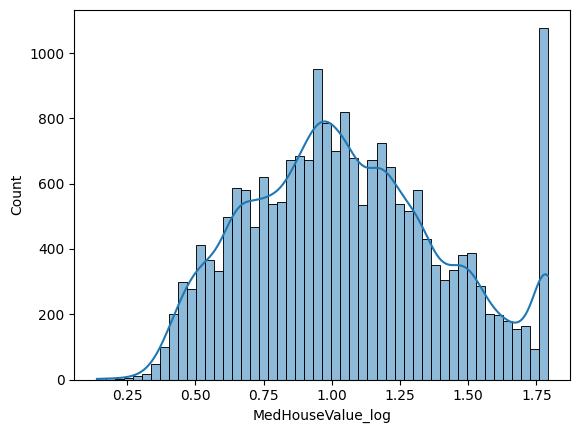

In [41]:
df['MedHouseValue_log'] = np.log1p(df['MedHouseValue'])
sns.histplot(df["MedHouseValue_log"], bins=50, kde=True)

#### Problem 2: Feature Interactions

- Some features, like AveBedrms and AveRooms, shows collinearity by corellation of 0.85. Therefore, we can focus on one predictor. 
- Other factors seems to have correlation, such as MedInc and AveRooms (0.33), HouseAge and Population (0.3). Thus, we can create one predictor combining those two factors.

In [43]:
df.drop(columns=["AveBedrms"], inplace=True)
df['MedInc_x_AveRooms'] = df['MedInc'] * df['AveRooms']
df['HouseAge_x_Population'] = df['HouseAge'] * df['Population']

#### Problem 3: Latitude and Longitude

Since both variables reflect the same information about location, we'll try to use PCA to combine them into one variation correlated geographically.

In [46]:
geo_pca = PCA(n_components=1)
df['Geo'] = geo_pca.fit_transform(df[['Latitude','Longitude']])
df.drop(columns=['Latitude','Longitude'], inplace=True)


### *Train-Test Split*

In [47]:
feature_cols = [col for col in df.columns if col not in ['MedHouseValue','MedHouseValue_log']]

X = df[feature_cols]
y = df['MedHouseValue_log']  # log-transformed target


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

### *Standardization*

In [54]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

cols_scale = [c for c in X.columns if c != 'Geo']

# Fit scaler on training data only for selected columns
scaler = StandardScaler()
X_train_scaled[cols_scale] = scaler.fit_transform(X_train[cols_scale])
X_test_scaled[cols_scale] = scaler.transform(X_test[cols_scale])

## Modelling

### Classic ML

We'll try to implement **gradient boosting baselines (XGB, LGBM)** as we can compare with deep neural nets approach. With this approach, we can justify the DL usage.

In order to avoid overfitting to the validation split when tuning hyperparameters, we utilize **Nested Cross-Validation** for ML models.

At the end, we wrap all things into a pipeline with *Scaling* and *VarianceThreshold*. This keeps preprocessing clean and avoids data leakage.

In [58]:
# Traditional ML

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

import lightgbm
from lightgbm import LGBMRegressor

import xgboost
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error


# Define scorers to make a negative MSE because GridSearchCV maximizes the score
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)


# Define the parameter grid
param_grids_xgb = {
  'regressor__n_estimators': [50, 100, 500, 1000],
  'regressor__learning_rate': [0.1, 0.01, 0.001],
  'regressor__max_depth': [None, 5, 7, 10],
  'regressor__min_child_weight': [1, 5, 10]
}

param_grids_lgb = {
  'regressor__n_estimators': [100, 1000, 10000],
  'regressor__eta': [0.1, 0.01, 0.001],
  'regressor__max_depth': [3, 5, 7, 10]
  }

#Create pipeline
pipe_xgb = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('selector', VarianceThreshold()),
    ('regressor', XGBRegressor(random_state=42))
    ])

pipe_lgb = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('selector', VarianceThreshold()),
    ('regressor', LGBMRegressor(random_state=42))
    ])

#Setup Outer & Inner Loop
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=2, shuffle=True, random_state=42)

result = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE'])

# For each model, run nested CV.
for name, pipe, param_grids in [
    ('XGBoost', pipe_xgb, param_grids_xgb),
    ('LightGBM', pipe_lgb, param_grids_lgb)
    ]:


  outer_scores_mse = []
  outer_scores_rmse = []
  outer_scores_mae = []

  #Outer Loop
  for train_idx, test_idx in outer_cv.split(X_train_scaled.values, y_train.values.ravel()):
    X_train_fold, X_valid_fold = X_train_scaled.values[train_idx], X_train_scaled.values[test_idx]
    y_train_fold, y_valid_fold = y_train.values.ravel()[train_idx], y_train.values.ravel()[test_idx]

    # Run grid search with inner CV
    grid_search = RandomizedSearchCV(pipe, param_distributions=param_grids, cv=inner_cv, scoring=mse_scorer, n_jobs=-1)
    grid_search.fit(X_train_fold, y_train_fold)

    #Best Estimator
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_valid_fold)
    mse = mean_squared_error(y_valid_fold, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_valid_fold, y_pred)
    outer_scores_mse.append(mse)
    outer_scores_rmse.append(rmse)
    outer_scores_mae.append(mae)


  result = pd.concat([results_table, pd.DataFrame({
        'Model':[name],
        'MSE':[np.mean(outer_scores_mse)],
        'RMSE':[np.mean(outer_scores_rmse)],
        'MAE':[np.mean(outer_scores_mae)]
    })], ignore_index=True)
  print(f"{name} | [outer CV] Mean MSE : {np.mean(outer_scores_mse):.4f} // Mean RMSE : {np.mean(outer_scores_rmse):.4f} // Mean MAE : {np.mean(outer_scores_mae):.4f}")

#Best model
best_model_name = min(result, key=result.get)
print("Best model:", best_model_name)

#Retrain on the entire training set
if best_model_name == 'XGBoost':
    final_pipe = pipe_xgb
    final_param_grid = param_grids_xgb
else:
    final_pipe = pipe_lgb
    final_param_grid = param_grids_lgb

final_grid = GridSearchCV(final_pipe, param_grid=final_param_grid, cv=inner_cv,
                          scoring=mse_scorer, n_jobs=-1)
final_grid.fit(X_train_scaled.values, y_train.values.ravel())
final_best_model = final_grid.best_estimator_

# Predict on test data.
y_test_pred = final_best_model.predict(X_test_scaled.values)

result_ml = pd.DataFrame(y_test_pred, columns=['predictions'])



NameError: name 'mean_absolute_error' is not defined

### Deep Learning

For Deep Learning implementation, we uses *Early Stopping* and *Scheduler*. Early stopping prevents wasting epochs on plateauing models, while LR scheduler ensures smoother convergence.

In [71]:
class RegressionMLP(nn.Module):
    def __init__(self, input_dim:int=data_train.shape[1], hidden_dim:int=64) -> None:
        super(RegressionMLP, self).__init__()
        #continue
        self.input_layer = nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=True)
        self.hidden_layer = nn.Linear(in_features=hidden_dim, out_features=hidden_dim, bias=True)
        self.output_layer = nn.Linear(in_features=hidden_dim, out_features=1, bias=True)

    def forward(self, x:pt.Tensor) -> pt.Tensor:
        #continue
        x = pt.relu(self.input_layer(x))
        x = pt.relu(self.hidden_layer(x))
        return self.output_layer(x)


In [72]:
device = pt.device('cuda' if pt.cuda.is_available() else 'cpu')
device

device(type='cpu')

4. Train model on `data_train` and `labels_train`:

In [73]:
def epoch(model:RegressionMLP,
          loader_train:DataLoader,
          optimizer:pt.optim.Optimizer,
          loss_fn:Callable[[pt.Tensor, pt.Tensor], pt.Tensor]) -> float:
  # 1. set model to train:
  model.train()

  losses = None if loss_fn is None else []
  with pt.enable_grad():
    for X_batch, y_batch in loader_train:
      # move tensors to correct device:
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      # reset all gradients to zero:
      optimizer.zero_grad()

      # create predictions:
      y_pred = model(X_batch)

      # calculate loss:
      loss = loss_fn(y_pred, y_batch)
      losses.append(loss_fn(y_pred, y_batch).detach().cpu().numpy())

      # backpropagate loss:
      loss.backward()

      # update weights:
      optimizer.step()

  return np.mean(losses)

def evaluate(model:RegressionMLP, loader_valid:DataLoader, loss_fn:Optional[Callable[[pt.Tensor, pt.Tensor], pt.Tensor]]=None) -> dict:
  # 1. set model to eval:
  model.eval()

  labels = []
  predictions = []
  losses = None if loss_fn is None else []
  for X_batch, y_batch in loader_valid:
    # move tensors to correct device:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    labels.extend(y_batch.cpu().detach().numpy())

    # create predictions:
    y_pred = model(X_batch)
    predictions.extend(y_pred.cpu().detach().numpy())

    # calculate loss:
    if loss_fn is not None:
      losses.append(loss_fn(y_pred, y_batch).detach().cpu().numpy())

  # calculate mse score:
  mse = mean_squared_error(
    np.array(labels).flatten(),
    np.array(predictions).flatten()
  )

  if loss_fn is None: return {'mse':mse}
  else: return {'loss':np.mean(losses), 'mse':mse}


def fit(model:RegressionMLP, loader_train:DataLoader, loader_valid:DataLoader, epochs:int, lr:float, patience:int) -> pd.DataFrame:
  # instantiate optimizer:
  optimizer = pt.optim.Adam(model.parameters(), lr=lr)

  # instantiate loss function:
  loss_fn = pt.nn.MSELoss()

  # add the scheduler
  scheduler = pt.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.33, total_iters=10)

  history = []
  early_stopping = EarlyStopping(patience=patience)

  for i in range(epochs):
    # train for one epoch:
    loss_train = epoch(model, loader_train, optimizer, loss_fn)

    # evaluate on validation:
    metrics = evaluate(model, loader_valid, loss_fn)

    # save metrics:
    history.append({
      'loss_train':loss_train,
      'loss_valid': metrics['loss'],
      'mse_valid': metrics['mse']
    })

    #print(f"Epoch {i+1}/{epochs}: Train Loss = {loss_train:.4f}, Val Loss = {loss_valid:.4f}")

    early_stopping.check_early_stop(metrics['loss'], model)
    if early_stopping.stop_training:
        print("Early stopping triggered!")
        model.load_state_dict(early_stopping.best_state_dict)
        break

    scheduler.step()

  # return history:
  return pd.DataFrame(history)


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False
        self.best_state_dict = None

    def check_early_stop(self, loss_valid, model):
        if self.best_loss is None or loss_valid < self.best_loss - self.delta:
            self.best_loss = loss_valid
            self.no_improvement_count = 0
            # Save a copy of the model's parameters.
            self.best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True



5. Predict `data_test` and save predictions to `submission.csv`:

In [75]:
#predictions = ...

In [76]:
#Convert training/validation splits to tensors.
X_train_tensor = pt.tensor(X_train, dtype=pt.float32)
y_train_tensor = pt.tensor(y_train, dtype=pt.float32).unsqueeze(1)
X_val_tensor = pt.tensor(X_val, dtype=pt.float32)
y_val_tensor = pt.tensor(y_val, dtype=pt.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
loader_train = DataLoader(train_ds, batch_size=64, shuffle=True)
loader_valid = DataLoader(val_ds, batch_size=64, shuffle=False)

#### GridSearch in MLP

<Axes: xlabel='epoch', ylabel='loss'>

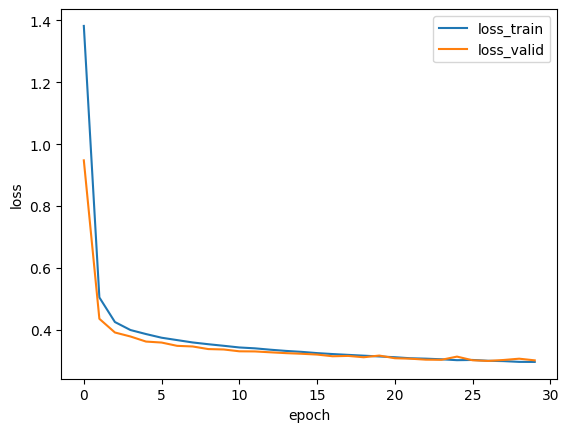

In [ ]:
hidden_dims = [32, 64, 128]
learning_rates = [1e-3, 5e-4, 1e-4]
dropouts = [0.0, 0.2, 0.5]

for hidden_dim, lr, dropout in product(hidden_dims, learning_rates, dropouts):
    # instantiate model and move to device:
    input_dim = X_train.shape[1]
    model = RegressionMLP(input_dim=X_train.shape[1], hidden_dim=hidden_dim, dropout=dropout).to(device)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=5)

    # train model:
    history = fit(model, loader_train, loader_valid, epochs=30, lr=0.001, patience=5)

    # plot history:
    history[['loss_train', 'loss_valid']].plot(xlabel='epoch', ylabel='loss')

In [ ]:
model.eval()
with pt.no_grad():
    predictions = model(pt.tensor(data_test_scaled, dtype=pt.float32).to(device)).cpu().numpy()

#save to CSV
result_dl = pd.DataFrame(predictions, columns=['predictions'])

---

*End of Task 5. Upload your final predictions (the file* `submission.csv` *) to **Homework 2 - Code** on **NextIlearn***